## Car Selling Price Prediction


In [1]:
#installing necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor 
import xgboost as xgb
import lightgbm as lgb
import joblib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## Data Collection and Preprocessing
car_dataset = pd.read_csv('car.csv')
car_dataset.describe()

,year,selling_price,km_driven,mileage(km/ltr/kg),engine,seats
count,8128.000000,8.128000e+03,8.128000e+03,7907.000000,7907.000000,7907.000000
mean,2013.804011,6.382718e+05,6.981951e+04,19.418783,1458.625016,5.416719
std,4.044249,8.062534e+05,5.655055e+04,4.037145,503.916303,0.959588
min,1983.000000,2.999900e+04,1.000000e+00,0.000000,624.000000,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,16.780000,1197.000000,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,19.300000,1248.000000,5.000000
75%,2017.000000,6.750000e+05,9.800000e+04,22.320000,1582.000000,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,42.000000,3604.000000,14.000000


(8128, 12)


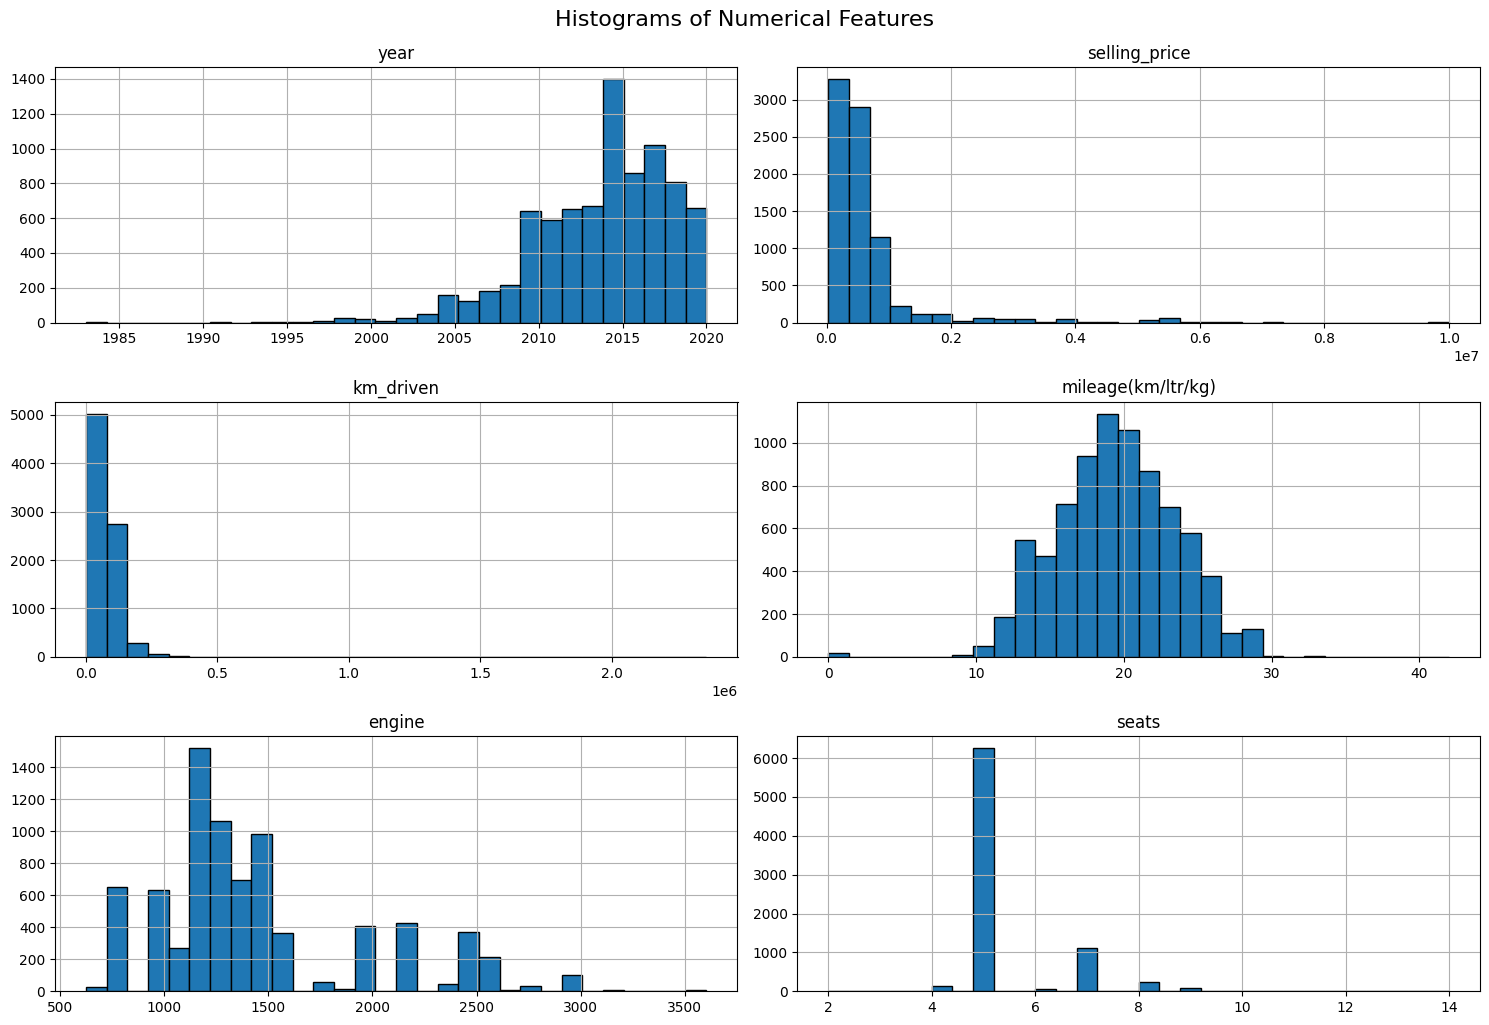

In [3]:
#inspecting the dataset
print(car_dataset.shape)
import matplotlib.pyplot as plt

# Select only numerical columns
numeric_cols = car_dataset.select_dtypes(include=['int64', 'float64']).columns

# Plot histogram for each numerical column
car_dataset[numeric_cols].hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.tight_layout()
plt.suptitle('Histograms of Numerical Features', fontsize=16, y=1.02)
plt.show()


Null rows in X_train

name                  0
year                  0
selling_price         0
km_driven             0
fuel                  0
seller_type           0
transmission          0
owner                 0
mileage(km/ltr/kg)    0
engine                0
max_power             0
seats                 0
Null rows in car_dataset: 0


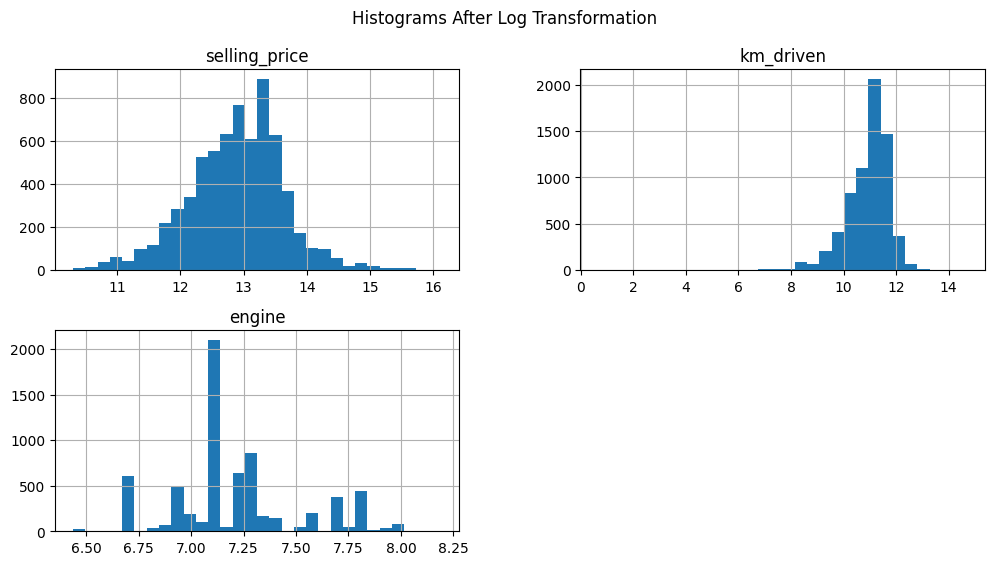

In [4]:
# Step 1: Clean the dataset
car_dataset = car_dataset.dropna()
car_dataset = car_dataset.drop_duplicates()

print("Null rows in X_train\n")
print(car_dataset.isnull().sum().to_string())

print("Null rows in car_dataset:", car_dataset.duplicated().sum())

# Step 2: Log-transform skewed numerical columns
log_cols = ['selling_price', 'km_driven', 'engine']
for col in log_cols:
    car_dataset[col] = np.log1p(car_dataset[col])  # handles 0 safely

car_dataset[log_cols].hist(bins=30, figsize=(12, 6))
plt.suptitle("Histograms After Log Transformation")
plt.show()
X = car_dataset.drop(['selling_price', 'name'], axis=1).copy()
y = car_dataset['selling_price']

# Now split cleaned and deduplicated data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

In [5]:
print("After transforming into logarthmic scale:")
car_dataset.describe()

After transforming into logarthmic scale:


,year,selling_price,km_driven,mileage(km/ltr/kg),engine,seats
count,6718.000000,6718.000000,6718.000000,6718.00000,6718.000000,6718.000000
mean,2013.609110,12.889422,10.941721,19.46531,7.214460,5.434653
std,3.900648,0.750575,0.814100,4.04915,0.316112,0.984230
min,1994.000000,10.308953,0.693147,0.00000,6.437752,2.000000
25%,2011.000000,12.429220,10.545368,16.80000,7.088409,5.000000
50%,2014.000000,12.948012,11.130530,19.44000,7.130099,5.000000
75%,2017.000000,13.384729,11.512935,22.50000,7.312553,5.000000
max,2020.000000,16.118096,14.674366,42.00000,8.190077,14.000000


In [6]:
# Identify numeric and categorical columns from X_train
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns

# Impute numeric on X_train and transform X_val
num_imputer = SimpleImputer(strategy='mean')
X_train[num_cols] = pd.DataFrame(
    num_imputer.fit_transform(X_train[num_cols]),
    columns=num_cols,
    index=X_train.index
)
X_val[num_cols] = pd.DataFrame(
    num_imputer.transform(X_val[num_cols]),
    columns=num_cols,
    index=X_val.index
)

# Impute categorical on X_train and transform X_val
cat_imputer = SimpleImputer(strategy='most_frequent')
X_train[cat_cols] = pd.DataFrame(
    cat_imputer.fit_transform(X_train[cat_cols]),
    columns=cat_cols,
    index=X_train.index
)
X_val[cat_cols] = pd.DataFrame(
    cat_imputer.transform(X_val[cat_cols]),
    columns=cat_cols,
    index=X_val.index
)

In [7]:
X_train.info()
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5374 entries, 3125 to 3076
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                5374 non-null   float64
 1   km_driven           5374 non-null   float64
 2   fuel                5374 non-null   object 
 3   seller_type         5374 non-null   object 
 4   transmission        5374 non-null   object 
 5   owner               5374 non-null   object 
 6   mileage(km/ltr/kg)  5374 non-null   float64
 7   engine              5374 non-null   float64
 8   max_power           5374 non-null   object 
 9   seats               5374 non-null   float64
dtypes: float64(5), object(5)
memory usage: 461.8+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 672 entries, 2596 to 135
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                672 non-null    float64
 1 

In [8]:
# Identify numeric and categorical columns from X_train
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns

# Preprocessing: scale numeric, one-hot encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ])

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42)
}

# Create pipelines
pipelines = {name: Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
]) for name, model in models.items()}

# Fit and evaluate all models
best_model = None
best_score = -np.inf

for name, pipe in pipelines.items():
    print(f"Training {name}...")
    pipe.fit(X_train, y_train)
    preds_log = pipe.predict(X_val)

    # Invert log1p transform for both prediction and true labels
    true_vals = np.expm1(y_val)
    pred_vals = np.expm1(preds_log)

    # Evaluate
    mae = mean_absolute_error(true_vals, pred_vals)
    r2 = r2_score(true_vals, pred_vals)
    print(f"{name} MAE: {mae:.2f}, R2: {r2:.3f}\n")

    # Track best overall model (optional)
    if r2 > best_score:
        best_score = r2
        best_model = pipe

# -------------------------
# Now, hyperparameter tuning for XGBoost using GridSearchCV on training data

pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(pipeline_xgb, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best parameters found by GridSearchCV:", grid_search.best_params_)
print("Best CV R2 score:", grid_search.best_score_)

# Save the best tuned model pipeline
joblib.dump(grid_search.best_estimator_, '../model/xgboost_pipeline_tuned.pkl')
print("✅ *Tuned XGBoost pipeline saved as 'xgboost_pipeline_tuned.pkl'*")


Training Linear Regression...
Linear Regression MAE: 107197.82, R2: 0.731

Training Random Forest...
Random Forest MAE: 91829.59, R2: 0.864

Training XGBoost...
XGBoost MAE: 88294.98, R2: 0.904

Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 5374, number of used features: 85
[LightGBM] [Info] Start training from score 12.889718


e:\ML_Project\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM MAE: 88412.74, R2: 0.893

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters found by GridSearchCV: {'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 200}
Best CV R2 score: 0.9052946513091584
✅ *Tuned XGBoost pipeline saved as 'xgboost_pipeline_tuned.pkl'*


In [9]:
# Custom R² scorer that inverts log1p
def r2_log_inverse(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return r2_score(y_true, y_pred)

# Use make_scorer to create a scorer usable in cross_val_score
r2_custom_scorer = make_scorer(r2_log_inverse, greater_is_better=True)

# Define pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Use cross_val_score with custom scorer
r2_scores = cross_val_score(pipeline, X, y, cv=5, scoring=r2_custom_scorer)

print("Cross-val R2 scores (actual scale):", r2_scores)
print("Mean R2:", r2_scores.mean())

Cross-val R2 scores (actual scale): [0.62368269 0.82030739 0.86631731 0.77690137 0.81856618]
Mean R2: 0.7811549879429658


In [10]:
# Load the entire pipeline (includes preprocessor + model)
pipeline = joblib.load('../model/xgboost_pipeline_tuned.pkl')

In [11]:
# Predict (still in log scale)
y_pred_log = pipeline.predict(X_test)

# Invert transformation to get actual prices
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)  # Only if y_val was log1p-transformed

r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print("Test R²:", r2)
print("Test MAE:", mae)

Test R²: 0.7815533791061092
Test MAE: 87556.60954938616
